# **Housing Prices Analysis**
Spring 2024 Data Science Project

Amruth Nare

# Introduction

In this Jupyter Notebook, I will conduct a thorough analysis on housing prices and the predictability of a house's sale price based on different independent variables. The overall purpose of this notebook will be to both perform a succesful analysis and take you through the entire data science life cycle.


Why is this important? From the advent of the 2008 subprime mortgage crisis, we have seen a consistent increase in the presence of Wall Street firms in the housing market. This problem is known as the **financialization of housing** and I first explored it years ago in a [short essay report](https://medium.com/@amruthnare.1/the-financialization-of-housing-and-its-effect-on-the-average-consumer-414ccc8611e9). At record peaks in late 2022 we saw Wall Street firms were responsible for [1/4 single family home purchases](https://www.wsj.com/real-estate/wall-street-has-spent-billions-buying-homes-a-crackdown-is-looming-f85ae5f6). With these firms buying up homes at high sales prices to corner the housing market, we see many young Americans struggle to afford homes.

By analyzing the various factors that drive a homes price, I hope to reveal some consistent methodology to help buyers in the home market to determine the value of the home based on its characteristics. By developing a machine learning technique to predict housing prices, future homebuyers can be more certain of the validity of a homes sale price rather than an inflated arbitrary price set by Wall Street.







# Data Load & Preprocessing

For this stage of the data science lifecycle we need to find some strong sources of data that we can utilize. Since we want to explore housing data we need a dataset that ideally contains features of houses as well as their sale price. For this I sourced from two different datasets the first being the prices data set which contains time series price data for different regions in the USA(https://www.zillow.com/research/data/). The second data source that I utilized was extremely detailed and was from Kaggle(https://www.kaggle.com/c/house-prices-advanced-regression-techniques/overview). This dataset however was not for the general USA geographic region, but was speciifcally was data from Ames, Iowa. Both of these data sources were offered as CSV files and can be easily loaded into our program.

In [75]:
# Basic preliminary imports
import math
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
import statsmodels.api as sm
import numpy as np

from scipy import stats
from sklearn.linear_model import LinearRegression


**ONLY IF USING GOOGLE COLAB!**


Download the CSV files from the website and then mount your google drive. After mounting place the files in your drive and replace the variables below with the proper file paths


In [76]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [77]:
prices_file = '/content/drive/MyDrive/Metro_zhvi_uc_sfrcondo_tier_0.33_0.67_sm_sa_month-2.csv'
housing_file = '/content/drive/MyDrive/train.csv'

Here we loaded in our prices dataset into a Pandas dataframe called prices for easier manipulation.

## Data Source 1 (Zillow)

In [78]:
prices = pd.read_csv(prices_file)
print(prices.head())

   RegionID  SizeRank       RegionName RegionType StateName     2000-01-31  \
0    102001         0    United States    country       NaN  120033.213118   
1    394913         1     New York, NY        msa        NY  214314.541751   
2    753899         2  Los Angeles, CA        msa        CA  225004.543761   
3    394463         3      Chicago, IL        msa        IL  149670.248748   
4    394514         4       Dallas, TX        msa        TX  125827.184072   

      2000-02-29     2000-03-31     2000-04-30     2000-05-31  ...  \
0  120244.390020  120506.280472  121067.984085  121714.437600  ...   
1  215225.257633  216144.408385  218006.963476  219935.703774  ...   
2  225841.846147  226957.124939  229176.155088  231603.078401  ...   
3  149808.799798  150072.672713  150729.122949  151518.753624  ...   
4  125883.227939  125947.656102  126114.969273  126335.567108  ...   

      2023-05-31     2023-06-30     2023-07-31     2023-08-31     2023-09-30  \
0  338064.442178  339983.42982

This dataset is time series data on various cities/regions in the United States. The data is tracking the median price of a home from 2000 to 2024 with the time steps being 1 month. Each row is a different city with prices data, region name, region type, and state name. The columns are the axis for time and as mentioned before are recorded every month.


**Time to reduce our data**

Here we use Pandas conditional filtering syntax to list the cities in Iowa that the Zillow dataset reports on. **Lets Go 😀!**  We got lucky and one of the cities that was tracked was Ames, IA which means we can easily merge this dataset with our other dataset later on.

In [79]:
print(prices[prices['StateName'] == 'IA']['RegionName'])
prices = prices[prices['RegionName'] == 'Ames, IA']

82       Des Moines, IA
175    Cedar Rapids, IA
244       Iowa City, IA
253        Waterloo, IA
288      Sioux City, IA
326            Ames, IA
384         Dubuque, IA
531    Fort Madison, IA
580      Mason City, IA
613         Clinton, IA
631      Burlington, IA
651       Muscatine, IA
677    Marshalltown, IA
739         Ottumwa, IA
850       Oskaloosa, IA
865      Storm Lake, IA
878     Spirit Lake, IA
884         Spencer, IA
886       Fairfield, IA
Name: RegionName, dtype: object


In [80]:
print(prices)

     RegionID  SizeRank RegionName RegionType StateName  2000-01-31  \
326    394325       336   Ames, IA        msa        IA         NaN   

     2000-02-29  2000-03-31  2000-04-30  2000-05-31  ...     2023-05-31  \
326         NaN         NaN         NaN         NaN  ...  238842.468771   

        2023-06-30     2023-07-31     2023-08-31     2023-09-30  \
326  240855.633292  242203.790851  243012.143392  243184.165015   

        2023-10-31     2023-11-30     2023-12-31     2024-01-31     2024-02-29  
326  242911.011567  242201.591237  241087.867471  239796.689795  239075.438255  

[1 rows x 295 columns]


As we can see from printing our new data, many of the initial time series data is missing as Zillow may not have recorded median home prices for Ames, IA in that time period.

This series had a alot of missing price values at the beginnning as Zillow had no data on Ames, Iowa then. In order to restrict this I grabbed the date of the first non NaN value which was 2009-03-31. Then I only grabbed the values after that first_data and stored it in *prices_adj*. The final data was a series of 180 median home prices in Ames recorded since 2009.

In [81]:
#Run only once or will overwrite data
first_date = prices.iloc[:, 7:].dropna(axis=1).columns[0]
print(first_date)

prices_adj = prices.loc[:, first_date:]


2009-03-31


Regularly we would not perform visualization during this stage of the data science life cycle. However to help get an initial sense of the data, I have plotted the price against time to see the change in median home prices in Ames, IA.

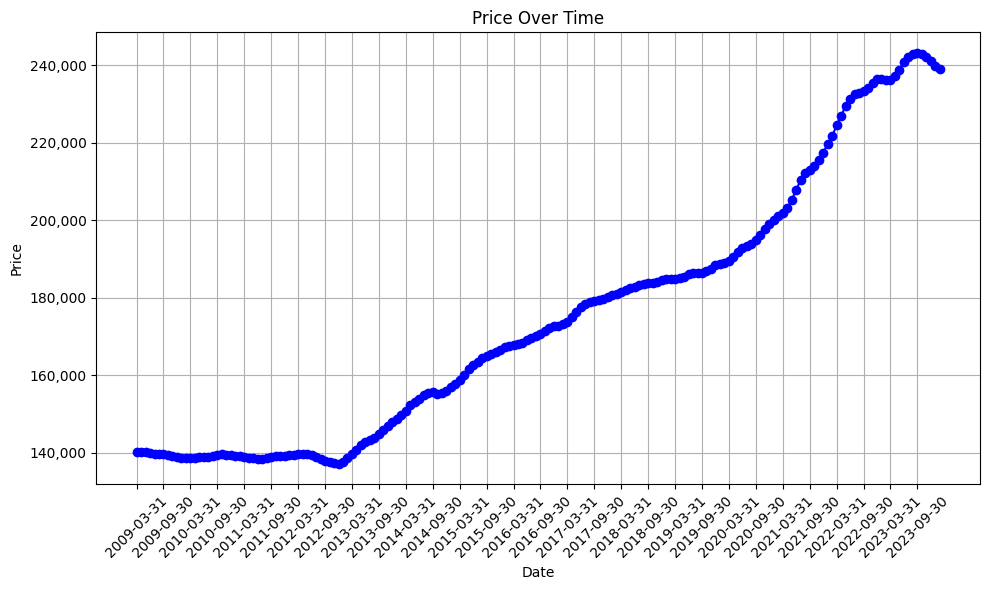

In [82]:
from matplotlib.ticker import StrMethodFormatter  # Import formatter for formatting tick labels

# Assuming 'prices' is your pandas DataFrame containing price data over time
# Plotting
plt.figure(figsize=(10, 6))  # Adjust figure size if needed

# Convert column labels and row data to numpy arrays
dates = prices_adj.columns.to_numpy()
values = prices_adj.iloc[0].values.astype(float)

# Plot using numpy arrays
plt.plot(dates, values, marker='o', linestyle='-', color='b')

# Customize plot labels and title
plt.title('Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid(True)

# Manually set x-axis ticks to show every Nth date (e.g., every 6 months)
N = 6
plt.xticks(dates[::N], rotation=45)  # Show every Nth date and rotate labels
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))

# Show plot
plt.tight_layout()
plt.show()


## Data Source 2 (Kaggle)

Here we will load in our dataset the same way into another dataframe called *df_housing*. As we can see by the shape of the data there are 81 different features available and 1460 rows of data or records of homes in Ames.

In [83]:
df_housing = pd.read_csv(housing_file)
print(df_housing)

        Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0        1          60       RL         65.0     8450   Pave   NaN      Reg   
1        2          20       RL         80.0     9600   Pave   NaN      Reg   
2        3          60       RL         68.0    11250   Pave   NaN      IR1   
3        4          70       RL         60.0     9550   Pave   NaN      IR1   
4        5          60       RL         84.0    14260   Pave   NaN      IR1   
...    ...         ...      ...          ...      ...    ...   ...      ...   
1455  1456          60       RL         62.0     7917   Pave   NaN      Reg   
1456  1457          20       RL         85.0    13175   Pave   NaN      Reg   
1457  1458          70       RL         66.0     9042   Pave   NaN      Reg   
1458  1459          20       RL         68.0     9717   Pave   NaN      Reg   
1459  1460          20       RL         75.0     9937   Pave   NaN      Reg   

     LandContour Utilities  ... PoolArea PoolQC  Fe

An explanation of each column(feature) can be found here [Kaggle Data](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data)

Now it is time to merge our Kaggle data and our Zillow data. Both dataframes utilize time so we can merge these datasets on that. However df_housing only lists by year, so we need to write a function to grab the median price for a home in Iowa based on the year a home record was sold in.

In [84]:
def get_median_price(row):
    year_sold = row['YrSold']
    key = str(year_sold) + "-12-31"
    return prices_adj[key]

df_housing = df_housing[df_housing['YrSold'] >= 2009]
df_housing['median_price'] = df_housing.apply(get_median_price, axis=1)
df_housing['diff_price'] = df_housing['SalePrice'] - df_housing['median_price']

Restricted the df_housing dataset to only include homes that were sold after 2009 to ensure that I had the appropriate time series data in the prices variables. Alongside this I grabbed the median sale price from the prices dataset and added it as a column for the df_housing to aggregate starting price data. Then as a reference variable I created a column to be the difference in the median price and the actual price.

## Missing Data

Before we begin any sort of analysis, we need to assess any missing data within our dataframe. Here we listed the counts of each feature that didnt have all 513 non NAN entries.

In [85]:
rows = df_housing.shape[0]
counts = df_housing.count()
print("Entries: ", rows)
print(counts[counts < rows])
counts = counts[counts < rows]

Entries:  513
LotFrontage     416
Alley            26
MasVnrType      204
MasVnrArea      511
BsmtQual        495
BsmtCond        495
BsmtExposure    495
BsmtFinType1    495
BsmtFinType2    494
FireplaceQu     261
GarageType      487
GarageYrBlt     487
GarageFinish    487
GarageQual      487
GarageCond      487
PoolQC            0
Fence           107
MiscFeature      25
dtype: int64


The numbers in the column are the number of non null entries for that feature.

In order to ease the cleansing process, I removed any variables that were missing more than 25% of its values for the homes. It would be meaningless to impute more than 25% of our data so it is better to just remove these features as they may damage our future models predictability.

This rule to not impute more than 25% of a features entries are missing is somewhat arbitrary. Here are some more sources on when to [impute vs delete](https://www.paultwin.com/wp-content/uploads/Lodder_1140873_Paper_Imputation.pdf) your data.

In [86]:
columns_to_drop = counts[counts < (rows * .75)].index
print(columns_to_drop)
df_housing.drop(columns_to_drop, axis=1, inplace=True)

Index(['Alley', 'MasVnrType', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature'], dtype='object')


In [87]:
counts = df_housing.count()
print("Entries: ", rows)
print(counts[counts < rows])
missing_columns = counts[counts < rows].index.tolist()

Entries:  513
LotFrontage     416
MasVnrArea      511
BsmtQual        495
BsmtCond        495
BsmtExposure    495
BsmtFinType1    495
BsmtFinType2    494
GarageType      487
GarageYrBlt     487
GarageFinish    487
GarageQual      487
GarageCond      487
dtype: int64


Before attempting to fill this remaining missing data we need to assess which portion of it is categorical and which is numerical. We can also preliminarily remove the GarageYrBlt from missing numerical data (will address this in later section).




**Why seperate categorical and numerical?**

We need to determine which columns are numerical vs categorical because when we perform imputation in the following steps we will use different methods for the different classes of variables.

In [88]:
df_imputed = df_housing.copy()

categorical_missing = [col for col in missing_columns if df_imputed[col].dtype == 'object']
numerical_missing = [col for col in missing_columns if df_imputed[col].dtype in ['int64', 'float64']]
numerical_missing.remove("GarageYrBlt")

print("Categorical: ", categorical_missing)
print("Numerical: ", numerical_missing)


Categorical:  ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']
Numerical:  ['LotFrontage', 'MasVnrArea']


### **Missing Not At Random (MNAR)**
Turns out due to the nature of our categorical data we cannot use imputation. This is because our categorical data is **MNAR** so we cannot use normal imputation methods to fill them as they do not represent the same distribution as the rest of our data. This makes sense by looking at the columns missing as they are all related to each other. The BsmtQual, BsmtExposure, BsmtFinType1, and BsmtFinType2 all pertain to the houses basement and measurements are probably due to a lack of a basement in the house. Likewise GarageType, GarageFinish, GarageQual, and GarageCond have the same issue. Since these sets of features share the same missing entries it will not hurt our data to remove them.


To remedy this we will just remove all of the rows with this data missing it is also less than **~8%** of the data so it will not hurt our training too much. Since it is a small portion of the data we can dismiss these rows as outliers as the vast majority of houses in Ames either have Basements or Garages.





### **KNN Imputation**

For our numerical columns I choose to use K Nearest Neighbors imputation rather than Hot Deck Imputation as I wanted multiple rows of data to weight in on the filled value. The advantage of this technique is that it maintains the variability of the data while also allowing you to assign distances as weights for the remaining columns. This way only the most similar records have a higher impact on the imputed value rather than all neighbors equally.

Additional Information: https://scikit-learn.org/stable/modules/generated/sklearn.impute.KNNImputer.html

In [89]:
from sklearn.impute import KNNImputer

# Remove rows with missing categorical values
df_imputed = df_imputed.dropna(subset=categorical_missing)

imputer = KNNImputer(n_neighbors=5, weights='distance')  # MAKE weights distance or uniform

# Impute numerical columns
df_imputed[numerical_missing] = imputer.fit_transform(df_imputed[numerical_missing])

print(df_imputed.shape)
df_housing = df_imputed.copy()

(470, 77)


After we have completed pre-processing our data we have 470 rows of home data in Ames, Iowa and 77 variables(columns) of data to describe each home.

## One Hot Encoding

Eventualy we will be using numerical techniques and machine learning to conduct primary analysis on our data. So during preprocessing it is essential to convert our categorical data to numerical. To do this I have used **One Hot Encoding** which converts the categorical columns into multiple binary columns for each possible category.

Additional Info: https://www.geeksforgeeks.org/ml-one-hot-encoding/

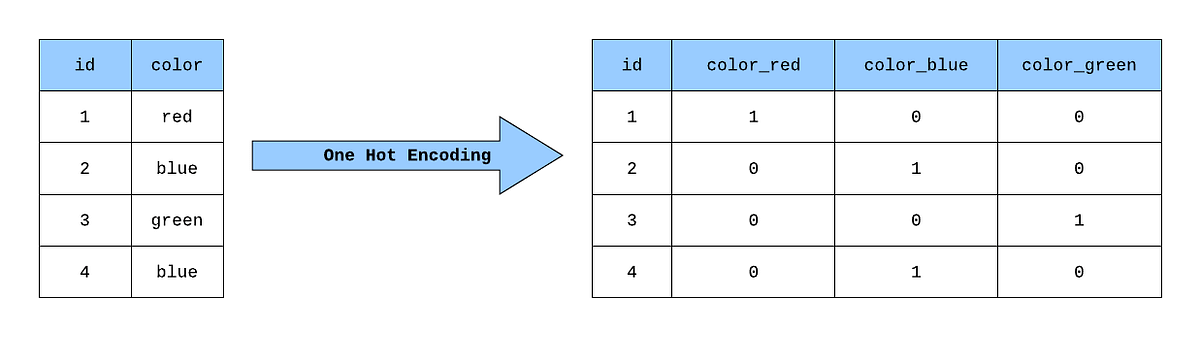

In [90]:
categorical_columns = df_housing.select_dtypes(include=['object', 'category']).columns.tolist()

dummies = pd.get_dummies(df_housing[categorical_columns], drop_first=True)
df_numerical = df_housing.drop(categorical_columns, axis=1)
df_encoded = pd.concat([df_numerical, dummies], axis=1)
print(df_encoded.shape)

(470, 199)


After this we have expanded our initial 77 columns of data to 199 columns and have a well curated dataset to work with

# Exploratory Data Analysis




Now that we have cleaned out full dataset we can move on to the Exploratory Data Analysis. During this stage of the data science lifecycle we will be attempting to determine the strength of different relationships of independent and dependent variables in our data. Alongside the analysis we will be graphing the data to better understand its relationship. Although we have our cleansed encoded dataframe available, we will be using the original df_housing as when we perform some of our tests we require the original categories.



## **Test 1: T test**
H0: The lot size of a house has no effect on its sale price

HA: The lot size of a house has an effect on its sale price


Based on intuition one of the biggest logical predictor of the Sale Price of a home would be the Lot Area(size). In order to assess the importance of this independent variable we can use a T test based on the hypothesis below. We are using a T Test here as we are attempting to determine the correlation between the lot size and sale price variables.

The T test will be done at a 95% confidence interval to determine whether the beta for the variable is 0.

In [91]:
ols = smf.ols(formula="SalePrice ~ LotArea", data=df_housing).fit()
print(ols.summary())
p_value = ols.pvalues['LotArea']
print(p_value)

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.078
Model:                            OLS   Adj. R-squared:                  0.076
Method:                 Least Squares   F-statistic:                     39.81
Date:                Thu, 09 May 2024   Prob (F-statistic):           6.49e-10
Time:                        07:13:17   Log-Likelihood:                -5955.4
No. Observations:                 470   AIC:                         1.191e+04
Df Residuals:                     468   BIC:                         1.192e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.635e+05   4943.657     33.072      0.0

Based on the results of our T-Test we can reject the null hypothesis, as our P Value for the LotArea coefficient was 6.795310263847286e-10. This value is < .05 so it is statistically significant.

We can also examine the R2 value here which is .078, this means that 7.8% of the variance in the Sale Price is attributed to the Lot Area.

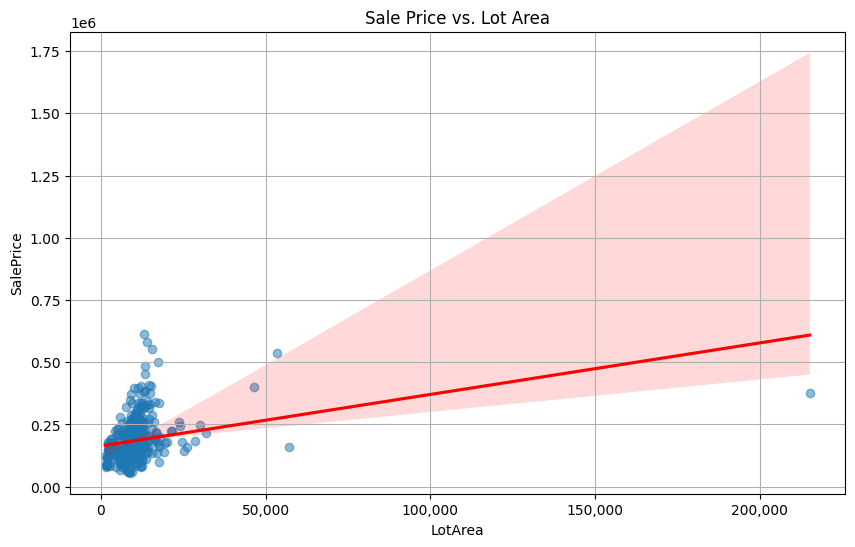

In [92]:
plt.figure(figsize=(10, 6))
plt.scatter(df_housing['LotArea'], df_housing['SalePrice'], alpha=0.5)
plt.title('Sale Price vs. Lot Area')
plt.xlabel('Lot Area(sq feet)')
plt.ylabel('Sale Price($)')

lot_area_limit = (0, df_housing['LotArea'].quantile(0.99))  # Limit to 99th percentile to avoid outliers
sale_price_limit = (0, df_housing['SalePrice'].quantile(0.99))


sns.regplot(x='LotArea', y='SalePrice', data=df_housing, scatter=False, color='red', label='Fitted line') #
plt.gca().xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))

plt.grid(True)
plt.show()

**Oh No! Outlier Spotted.**

Although our Lot Size did show correlation with the output Sale Price based on our p value. When we visualize this data against each other it is clear that it is being skewed by outlier data points. These outlier data points are where large plots of land are sold at relatively cheap prices.


This points towards the use of *some technique(lasso)* that we can use in our primary analysis to reduce the effect of outliers.

We can also preliminarily remove these outliers as they are only damaging to our future machine learning model.

In [93]:
df_encoded.sort_values(by = 'LotArea', ascending = False)[:1]

df_encoded = df_encoded.drop(df_encoded[df_encoded['Id'] == 314].index)

## **Test 2: Chi Squared Test**

H0: The neighborhood a house is in has no effect on the type of the building.

HA: The neighborhood a house is in has an effect on the type of the building.




While we can regress most of data against the SalePrice, it is also important to recognize the relationship between different predictors. For this we can use a [Chi Squared Test](https://www.bmj.com/about-bmj/resources-readers/publications/statistics-square-one/8-chi-squared-tests) at a 95% confidence interval.

In [94]:
print(df_housing['Neighborhood'].unique())
print(df_housing['BldgType'].unique())

['Mitchel' 'NWAmes' 'NAmes' 'Sawyer' 'NridgHt' 'CollgCr' 'IDOTRR'
 'Somerst' 'OldTown' 'Gilbert' 'MeadowV' 'Crawfor' 'Edwards' 'SawyerW'
 'Timber' 'BrkSide' 'ClearCr' 'StoneBr' 'NPkVill' 'BrDale' 'Blmngtn'
 'NoRidge' 'SWISU' 'Blueste']
['1Fam' 'TwnhsE' 'Duplex' 'Twnhs' '2fmCon']


Both the the Neighborhood and the BuildingType are categorical variables that in our final analysis can be used as independent variables to predict housing price. In order to determine if there is any correlation between them, and prevent multi-collinearity, I will use a Chi-Squared test.

In [95]:
contingency_table = pd.crosstab(df_housing['Neighborhood'], df_housing['BldgType'])
res = stats.chi2_contingency(contingency_table)
print("P Value: ", res.pvalue)

P Value:  7.79660985346173e-46


Based on the results of our Chi Squared Test we can reject the null hypothesis, as our P Value was ~1.44e-45. This value is < .05 so it is statistically significant. This means that statistically the variation in the Building Type can be explained by the Neighborhood the building is in.

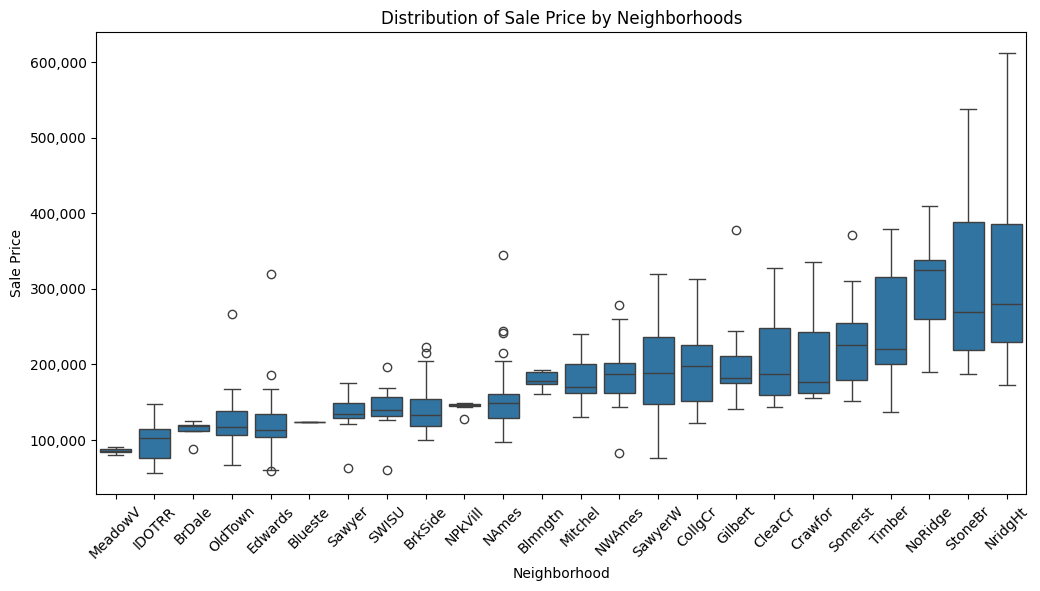

In [96]:
mean_by_neighborhood = df_housing.groupby('Neighborhood')['SalePrice'].mean()

# Plot distribution of SalePrice by Neighborhoods
plt.figure(figsize=(12, 6))
sns.boxplot(x='Neighborhood', y='SalePrice', data=df_housing, order=mean_by_neighborhood.sort_values().index)
plt.xticks(rotation=45)
plt.title('Distribution of Sale Price by Neighborhoods')
plt.xlabel('Neighborhood')
plt.ylabel('Sale Price')
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))

plt.show()

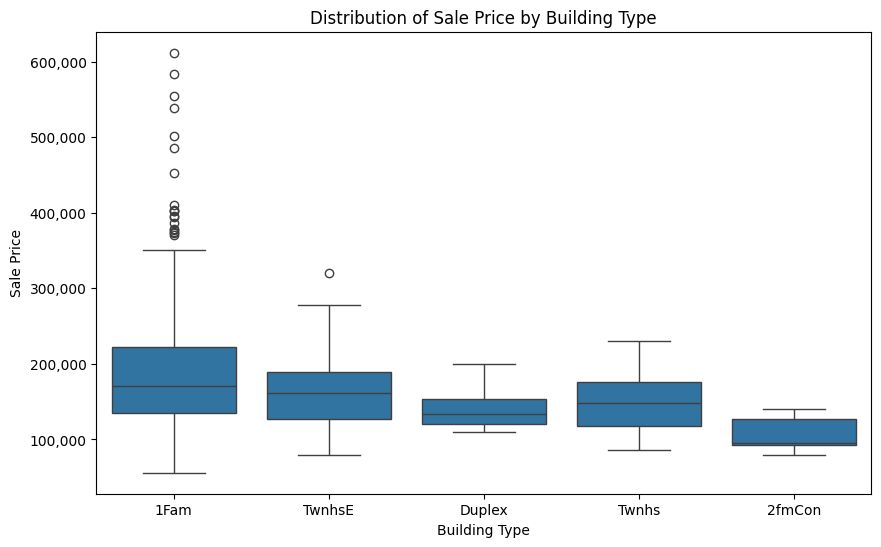

In [97]:

# Plot distribution of SalePrice by Building Type
plt.figure(figsize=(10, 6))
sns.boxplot(x='BldgType', y='SalePrice', data=df_housing)
plt.title('Distribution of Sale Price by Building Type')
plt.xlabel('Building Type')
plt.ylabel('Sale Price')
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))

plt.show()

By graphing these two categorical variables against the dependent sale price we can assess their own relative distributions. The first distribution of the mean sale price by neighborhood shows that there is not an even distribution of sale prices per neighborhood. Rather the neighborhood that you are in drives the distribution of sale prices this works in conjuction with the result of hypothesis hypothesis test.


These visualizations make sense in our world as single family homes are the most common and have the widest variability in sale price as people of all income purchase them.

## **Test 3: ANOVA Test category**

H0: There is no significant difference in SalePrice among different categories of LandContour.

HA: There is a significant statistical difference in SalePrice among different categories of LandContour.

When assessing the correlation between our numerical output and a categorical input we can use the [ANOVA test](https://www.qualtrics.com/experience-management/research/anova/). ANOVA works by comparing the means of many different groups often categories to describe some relationship or variance.

In [98]:
print(df_housing['LandContour'].unique())
contour_means = df_housing.groupby('LandContour')['SalePrice'].mean()
print(contour_means)


['Lvl' 'Bnk' 'HLS' 'Low']
LandContour
Bnk    135931.333333
HLS    259627.600000
Low    234960.000000
Lvl    184302.034722
Name: SalePrice, dtype: float64


The LandContour category measures the flatness of a given property by 4 different categories. The categories are Lvl(Leveled), Bnk(Banked), HLS(Hillside), and Low(Depressed). When grabbing the mean of the Sales price for each category, there is difference between the means however for a true test of difference in the categorical variable we need to use ANOVA.

In [99]:
landcontour_groups = df_housing.groupby('LandContour')['SalePrice'].apply(list)
print(landcontour_groups)
anova_result = stats.f_oneway(*landcontour_groups)
print(anova_result)

LandContour
Bnk    [110000, 140000, 153337, 214500, 110000, 12800...
HLS    [163500, 135000, 224500, 102776, 538000, 20100...
Low    [375000, 260000, 123000, 275000, 316600, 14300...
Lvl    [143000, 200000, 149000, 139000, 154000, 25630...
Name: SalePrice, dtype: object
F_onewayResult(statistic=6.644505026947182, pvalue=0.00021140310329770436)


Based on the results of our ANOVA Test we can reject the null hypothesis, as our P Value was 0.004908. This value is < .05 so it is statistically significant. This tells us that there is some statistical difference in SalePrice across houses with different LandContours.

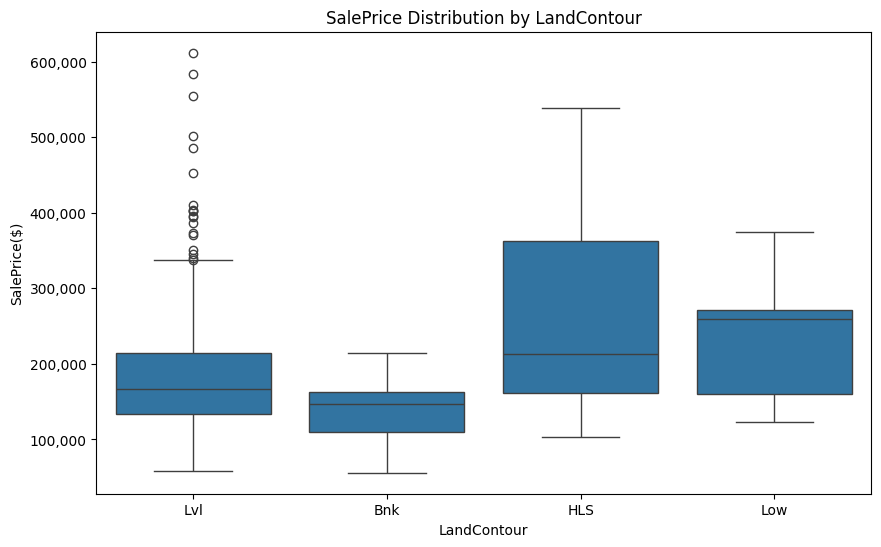

In [100]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='LandContour', y='SalePrice', data=df_housing)
plt.title('SalePrice Distribution by LandContour')
plt.xlabel('LandContour')
plt.ylabel('SalePrice($)')
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))

plt.show()

The multiple box charts make it evident that the categorical data(Land Countour) has a statistical difference on the SalesPrice. This is clear as the distribution of these values is different and the median price as per the line in the box vary by ~50,000 for each category.

We can also observe here that the HLS land has the widest range in prices as per their 25th and 75th percentile. The banked houses as expected had the lowest house prices as that style of property is generally considered unfavorable.

## **Preventing Multicollinearity**


**Multicollinearity**: Is a statistical phenomena where multiple independent variables are highly correlated with each other.

Problems:
*   Leads to unreliable coefficients(betas).
  * Small changes to data can largely affect the coefficients
  * Harder to interpret predictability of any given variable as they are confounded
*   Leads to redundant variables and coefficients
*   Can cause skewed results

Since multi-collinearity causes so many issues within our future models. We will aim to remove a few of these highly correlated variables now based on their correlation coefficients.


Additional Information: https://statisticsbyjim.com/regression/multicollinearity-in-regression-analysis/

In [101]:
correlation_matrix = df_encoded.drop(['SalePrice', 'median_price', 'diff_price'], axis=1).corr().abs()


highest_corr = (correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))
                 .stack()
                 .sort_values(ascending=False))

top_corr_pairs = highest_corr.head(10)
print(top_corr_pairs)

Exterior1st_CBlock   Exterior2nd_CBlock       1.000000
SaleType_New         SaleCondition_Partial    0.978694
Exterior1st_VinylSd  Exterior2nd_VinylSd      0.972896
Exterior1st_MetalSd  Exterior2nd_MetalSd      0.970700
Exterior1st_CemntBd  Exterior2nd_CmentBd      0.952308
RoofStyle_Gable      RoofStyle_Hip            0.951101
GarageQual_Fa        GarageQual_TA            0.940725
MSZoning_FV          Neighborhood_Somerst     0.937371
ExterCond_Gd         ExterCond_TA             0.928729
TotalBsmtSF          1stFlrSF                 0.905466
dtype: float64


The correlation matrix was computed on the encoded dataframe which contains the one hot encoded labels. Most of the top pairs in the resulting matrix were encoded labels. While normally we would remove these variables with perfect correlation or above 95% it does not make sense as they are correlated to their generated encoded labels not the raw data.
*   Exterior1st_CBlock   Exterior2nd_CBlock       1.000000
*   SaleType_New         SaleCondition_Partial    0.978697
*   Exterior1st_VinylSd  Exterior2nd_VinylSd      0.970668
*   Exterior1st_MetalSd  Exterior2nd_MetalSd      0.962943
*  Exterior1st_CemntBd  Exterior2nd_CmentBd      0.956288

The presence of one feature means the absence of the other categories. Due to this we need to calculate the top pairs only on the numerical columns not the categorical ones.













In [102]:
correlation_matrix = df_numerical.drop(['SalePrice', 'median_price', 'diff_price'], axis=1).corr().abs()

print((correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))
                 .stack()
                 .sort_values(ascending=False)).head())

TotalBsmtSF  1stFlrSF        0.906541
YearBuilt    GarageYrBlt     0.837849
GarageCars   GarageArea      0.837624
GrLivArea    TotRmsAbvGrd    0.835504
BsmtFinSF1   BsmtFullBath    0.645256
dtype: float64


Now these pairings of variables make much more sense, at this point we need to logically assess each of these pairings to see which of the features may intrinsically be tied to each other.

Instantly two pairs come to mind
1.   Year Built & GarageYrBuilt
2.   Garage Cars & GarageArea



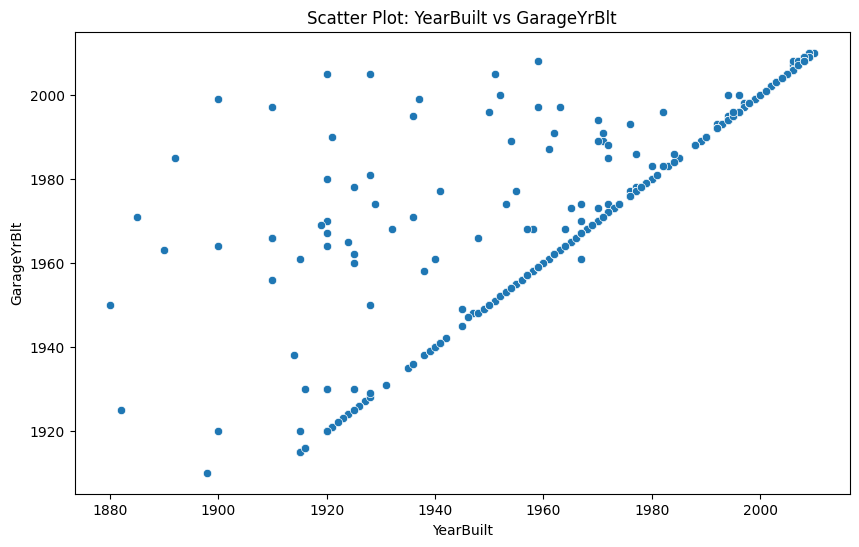

In [103]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x="YearBuilt", y="GarageYrBlt", data=df_encoded)
plt.title(f'Scatter Plot: YearBuilt vs GarageYrBlt')
plt.xlabel("YearBuilt")
plt.ylabel("GarageYrBlt")
plt.show()

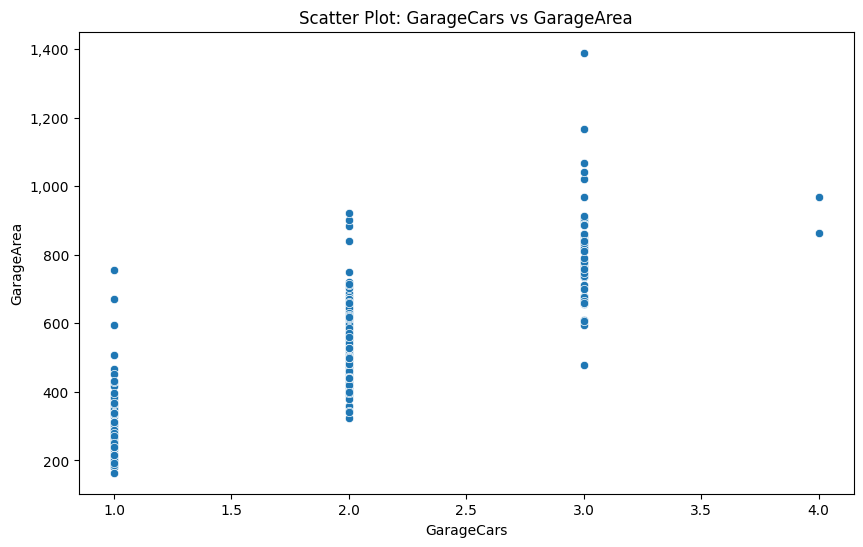

In [104]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x="GarageCars", y="GarageArea", data=df_encoded)
plt.title(f'Scatter Plot: GarageCars vs GarageArea')
plt.xlabel("GarageCars")
plt.ylabel("GarageArea")
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))

plt.show()

Based on the two plots it is clear to see that these pairs of independent features are highly correlated and may cause ambiguity in their statistical significance. This logically also makes sense as the number of cars in a garage is tied to the garage area in square feet. Alongside this the overwhelming majority of homes are constructed with a garage which is why most garage year built will be same as year built.

In [105]:
processed_df = df_encoded.copy()

variables_to_remove = ['GarageCars', 'GarageYrBlt']
processed_df = processed_df.drop(variables_to_remove, axis=1)

print(processed_df.shape)

(469, 197)


## **The Main Variable: SalePrice**



Regardless of the effectiveness of our different independent variables after preprocessing and reducing our variables for collinearity, our model is still dependent on the SalePrice. Before we craft our model we need to assess SalePrice as our dependent variable.

So lets look at the distribution of our SalePrice.



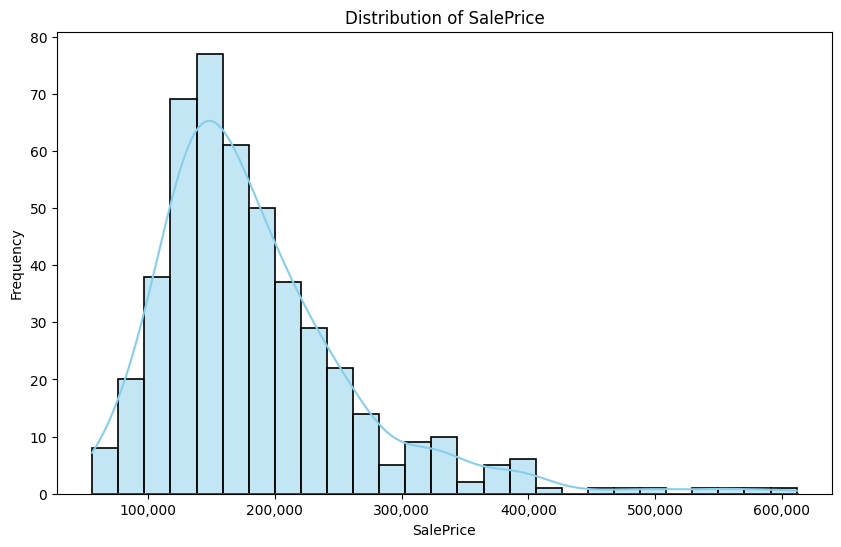

In [106]:
from scipy.stats import norm

plt.figure(figsize=(10, 6))

# Plot the distribution of SalePrice using seaborn's histogram (with KDE overlay)
#sns.displot(df_housing['SalePrice'], kde=True, color='skyblue')


sns.histplot(df_housing['SalePrice'], kde=True, color='skyblue', edgecolor='black', linewidth=1.2)

mu, sigma = norm.fit(df_housing['SalePrice'])
x = np.linspace(df_housing['SalePrice'].min(), df_housing['SalePrice'].max(), 100)
pdf = norm.pdf(x, mu, sigma)
plt.plot(x, pdf, label='Fitted Normal Curve', color='red', linewidth=2)

plt.title('Distribution of SalePrice')
plt.xlabel('SalePrice')
plt.ylabel('Frequency')
plt.gca().xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))


# Show the plot
plt.show()

We can clearly see that this distribution is not normal, which means our linear models which are more suited to normal distributions may not perform as well.

The data is right skewed and doesnt properly fit the normal distribution when we plotted it over. We will need to take this into account for our primary analysis to ensure that our linear models dont poorly fit the data.

**We will fix this later on in the primary analysis!**

# Primary Analysis

Based on the results of the exploratory analysis and preprocessing we can presume that the remaining independent variables in our dataframe can be utilized to predict the Sale Price of a home.

## **Linear Regression**

We can begin by creating a preliminary linear regression model that predicts the SalePrice based on the remaining independent variabkles in our processed_df


In [107]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score



features = df_encoded.drop(['Id', 'SalePrice', 'diff_price'], axis=1)
target = df_encoded['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)


model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")



coefficients = model.coef_
feature_names = features.columns

# Create a DataFrame to display coefficients and corresponding feature names
coefficients_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})

coefficients_df['AbsoluteCoefficient'] = abs(coefficients_df['Coefficient'])
sorted_coefficients = coefficients_df.sort_values(by='AbsoluteCoefficient', ascending=False)


results_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
print(results_df.head())
print(sorted_coefficients)


r2 = r2_score(y_test, y_pred)
print(f"R-squared Score: {r2}")


Mean Squared Error: 1298426490.825384
      Actual      Predicted
188   153337   73077.979545
233   128200  146730.587604
101   178000  186235.600641
1391  124000   40696.013989
1332  100000   64466.508839
                Feature   Coefficient  AbsoluteCoefficient
103    RoofMatl_Tar&Grv -9.576579e+04         9.576579e+04
85     Condition2_Feedr -9.355854e+04         9.355854e+04
104    RoofMatl_WdShake -8.835143e+04         8.835143e+04
102      RoofStyle_Shed  8.472996e+04         8.472996e+04
126  Exterior2nd_Stucco  7.314169e+04         7.314169e+04
..                  ...           ...                  ...
2               LotArea  1.365772e+00         1.365772e+00
28          OpenPorchSF -1.289304e+00         1.289304e+00
35               YrSold  1.646011e-02         1.646011e-02
32             PoolArea  1.296939e-09         1.296939e-09
83      Condition1_RRNe -1.200533e-10         1.200533e-10

[196 rows x 3 columns]
R-squared Score: 0.7294724011745631


The results of our linear regression can be interpreted largely by the R^2 score. The R^2 for our model was pretty high at .7294 which means 72.94% of the variance in our SalePrice can be attributed to our model and its coefficients.




## **Improvements to Model**

BUT! We still have improvements to make. Time to bring back the SalePrice distribution we were talking about earlier. The distribution we graphed earlier better wasnt normally distributed so we can perform a log transformation on the SalePrice to reduce this skew.

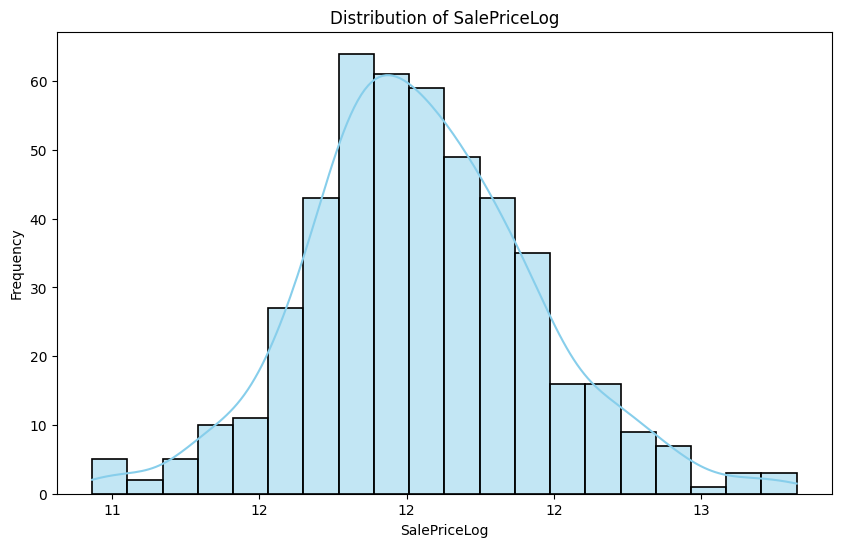

In [108]:
df_encoded['SalePriceLog'] = np.log1p(df_encoded["SalePrice"])


plt.figure(figsize=(10, 6))

# Plot the distribution of SalePrice using seaborn's histogram (with KDE overlay)
#sns.displot(df_housing['SalePrice'], kde=True, color='skyblue')


sns.histplot(df_encoded['SalePriceLog'], kde=True, color='skyblue', edgecolor='black', linewidth=1.2)

mu, sigma = norm.fit(df_encoded['SalePriceLog'])
x = np.linspace(df_encoded['SalePriceLog'].min(), df_encoded['SalePriceLog'].max(), 100)


plt.title('Distribution of SalePriceLog')
plt.xlabel('SalePriceLog')
plt.ylabel('Frequency')
plt.gca().xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))


# Show the plot
plt.show()

WOW! Our data now mcuh better matches a normal distribution and our linear models will be able to take advantage of this when regressing against our predictor variables.


### Lasso Reggression

Alongside this normalization of the SalePrice we can build a new model that also uses Lasso Regression.

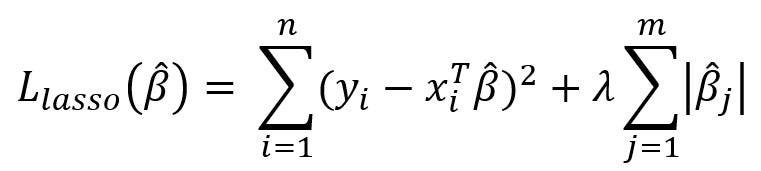

Lasso Regression allows us to attach an additional penalizer to our cost function whose goal it is to perform some feature selection within the model. This added term penalizes models that attach weights(betas) to more variables in order to prevent overfitting and creating models that cannot be generalized. By adding this term Lasso Regression will shrink/minimize irrelevant predictor variables to near 0 so that they do not affect the predictability of the model.

In [109]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd

# Assuming df_encoded is your dataframe containing encoded data

features = df_encoded.drop(['Id', 'SalePrice', 'SalePriceLog', 'diff_price'], axis=1)
target = df_encoded['SalePriceLog']

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Create and fit the Lasso model
alpha = 1.0  # You can adjust alpha based on regularization strength
lasso_model = Lasso(alpha=alpha)
lasso_model.fit(X_train, y_train)

# Make predictions
y_pred_log = lasso_model.predict(X_test)

y_pred = np.expm1(y_pred_log)  # Use np.expm1 to reverse log transformation


# Evaluate the model
mse = mean_squared_error(np.expm1(y_test), y_pred)
print(f"Mean Squared Error: {mse}")

# Get coefficients and feature names
coefficients = lasso_model.coef_
feature_names = features.columns

# Create a DataFrame to display coefficients and corresponding feature names
coefficients_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})

coefficients_df['AbsoluteCoefficient'] = abs(coefficients_df['Coefficient'])
sorted_coefficients = coefficients_df.sort_values(by='AbsoluteCoefficient', ascending=False)

# Display top coefficients
print(sorted_coefficients.head(10))

# Calculate R-squared
r2 = r2_score(np.expm1(y_test), y_pred)
print(f"R-squared Score: {r2}")

# Display actual vs predicted values
results_df = pd.DataFrame({'Actual': np.expm1(y_test), 'Predicted': y_pred})
print(results_df.head())


Mean Squared Error: 994213287.2819597
         Feature  Coefficient  AbsoluteCoefficient
5      YearBuilt     0.002220             0.002220
6   YearRemodAdd     0.001974             0.001974
26    GarageArea     0.000300             0.000300
11   TotalBsmtSF     0.000293             0.000293
15     GrLivArea     0.000242             0.000242
13      2ndFlrSF     0.000138             0.000138
8     BsmtFinSF1     0.000122             0.000122
28   OpenPorchSF     0.000120             0.000120
31   ScreenPorch     0.000073             0.000073
33       MiscVal     0.000042             0.000042
R-squared Score: 0.7928553250960252
        Actual      Predicted
188   153337.0  162338.757656
233   128200.0  118844.072467
101   178000.0  166324.617449
1391  124000.0  188638.779502
1332  100000.0  105764.756005


# Visualization

# Insights

During this final stage of the data science life cycle we will be using our final models results to draw conclusions to the questions we posed in the introduction.

## Top Predictor Variables

One of the most important pieces of information and that which this entire project has been centered around is the selection of features within homes that drive the price. Based on our Lasso Regression we were able to determine the 8 most important features of a house in terms of its absolute effect on the SalePrice.

Through this notebook, we have performed data processing, exploratory analysis, hypothesis testing, and machine learning model development to gain insights on the black box that is the housing market. While we focused on localized data for Ames, IA the pipeline/methodology we have build can be applied to many different regions and grant insights to new buyers in the housing market.